In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
PLT_CELL = 3.5

In [212]:
import glob
# DATA_PATH = "../data/simulation/Synthetic/"
DATA_PATH = "../tools/BoolODE/Synthetic/"
s = "TF"
paths = glob.glob(os.path.join(DATA_PATH, f"dyn-{s}/dyn-{s}*")) + glob.glob(os.path.join(DATA_PATH, f"dyn-{s}_ko*/dyn-{s}*"))
names = [os.path.basename(p).split("-")[1] for p in paths]

In [213]:
paths

['../tools/BoolODE/Synthetic/dyn-TF/dyn-TF-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g5/dyn-TF_ko_g5-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g7/dyn-TF_ko_g7-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g2/dyn-TF_ko_g2-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g3/dyn-TF_ko_g3-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g8/dyn-TF_ko_g8-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g6/dyn-TF_ko_g6-1000-1',
 '../tools/BoolODE/Synthetic/dyn-TF_ko_g4/dyn-TF_ko_g4-1000-1']

In [214]:
def load_adata(path):
    adata = ad.AnnData(pd.read_csv(os.path.join(path, "ExpressionData.csv"), index_col = 0).T)
    df_pt = pd.read_csv(os.path.join(path, "PseudoTime.csv"), index_col = 0)
    df_pt[np.isnan(df_pt)] = 0
    adata.obs["t_sim"] = np.max(df_pt.to_numpy(), -1)
    sc.pp.log1p(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata, min_dist = 0.9)
    return adata
adatas = [load_adata(p) for p in paths]

In [215]:
T = 8
t_bins = np.linspace(0, 1, T+1)[:-1]
def bin_timepoints(adata):
    adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins)-1
for adata in adatas:
    bin_timepoints(adata)

In [216]:
kos = []
for p in paths:
    try:
        kos.append(os.path.basename(p).split('_ko_')[1].split("-")[0])
    except:
        kos.append(None)
kos

[None, 'g5', 'g7', 'g2', 'g3', 'g8', 'g6', 'g4']

In [217]:
# for (adata, name) in zip(adatas, names):
#     sc.pl.scatter(adata, basis = "pca", color = "t", title = name,)

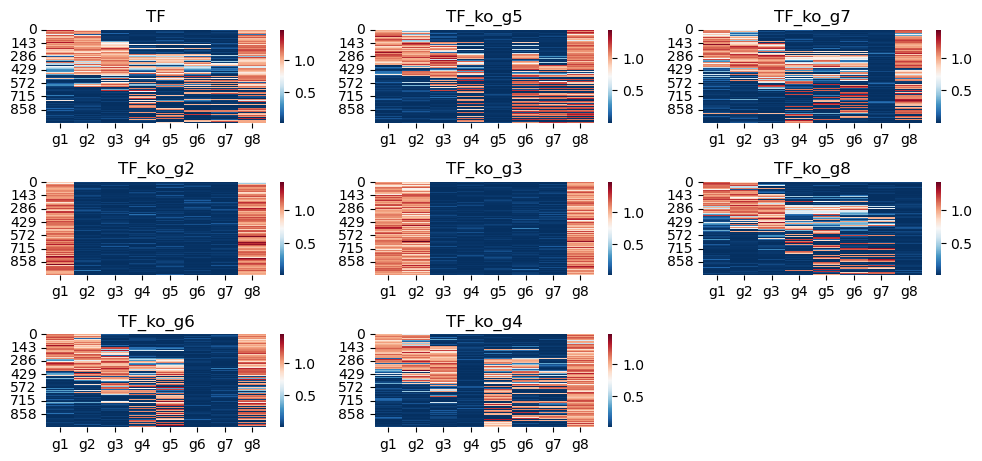

In [218]:
import seaborn as sb
plt.figure(figsize = (10, 6))
for i, (adata, name) in enumerate(zip(adatas, names)):
    plt.subplot(4, 3, i+1)
    sb.heatmap(pd.DataFrame(adata.X[np.argsort(adata.obs.t), :], columns = adata.var.index), cmap = "RdBu_r")
    plt.title(name)
    plt.axis("auto")
plt.tight_layout()

In [219]:
A_refs = []
for p, name in zip(paths, names):
    df = pd.read_csv(os.path.join(os.path.dirname(p), "refNetwork.csv"))
    n_genes = adata.shape[1]
    A_ref = pd.DataFrame(np.zeros((n_genes, n_genes), int), index = adata.var.index, columns=adata.var.index)
    for i in range(df.shape[0]):
        _i = df.iloc[i, 1]
        _j = df.iloc[i, 0]
        _v = {"+" : 1, "-" : -1}[df.iloc[i, 2]]
        A_ref.loc[_i, _j] = _v
    # plt.figure(figsize = (3, 3));
    # sb.heatmap(A_ref, vmin = -1, vmax = 1, cmap = "RdBu_r"); plt.gca().invert_yaxis()
    # plt.title(name)
    A_refs.append(A_ref)

In [220]:
import networkx as nx
_A = A_refs[np.where(np.array(kos) == None)[0][0]]
np.fill_diagonal(_A.values, 0)
g = nx.DiGraph(_A)
centralities = nx.centrality.eigenvector_centrality(g)

/tmp/ipykernel_1065375/1580778694.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


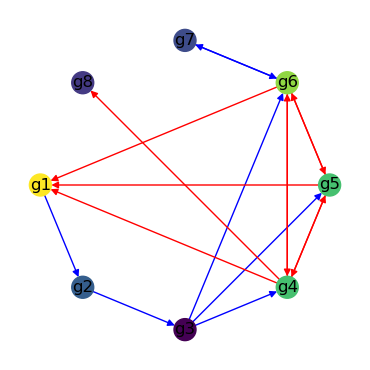

In [221]:
nx.set_node_attributes(g, centralities, name = "centrality")
plt.figure(figsize = (PLT_CELL, PLT_CELL))
edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]
nx.draw(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 2.5e2, pos=nx.shell_layout(g))
plt.tight_layout()
plt.savefig("../figures/TF_net_true.pdf")

In [222]:
kos

[None, 'g5', 'g7', 'g2', 'g3', 'g8', 'g6', 'g4']

In [223]:
centralities = pd.Series(centralities)
ko_genes = centralities.index[np.argsort(np.array(centralities))[::-1]][:4]

ko_idx = [np.where(np.array(kos) == None)[0][0], ]
for x in ko_genes:
    try:
        ko_idx.append(np.where(np.array(kos) == x)[0][0])
    except:
        pass
ko_idx

[0, 6, 1, 7]

In [224]:
[kos[i] for i in ko_idx]

[None, 'g6', 'g5', 'g4']

In [342]:
import sys
sys.path.append("../src/")
import importlib
import rf
importlib.reload(rf)
import torch

In [346]:
options = {
    "lr" : 0.1, 
    "reg_sinkhorn" : 0.1,
    "reg_A" : 1e-3, 
    "reg_A_elastic" : 0, 
    "iter" : 1000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam
}

In [347]:
estim_alt = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

/home/syz/Projects/temporal_perturb/notebooks/../src/rf.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -0.967980333682918, L = -0.967980333682918, R = 0.0
iteration 100, loss = -1.3426671616738963, L = -1.4000995859876242, R = 57.432424313727836
iteration 200, loss = -1.3498885492930601, L = -1.40582425142474, R = 55.935702131680024
iteration 300, loss = -1.385673110250508, L = -1.4489927255045358, R = 63.31961525402774
iteration 400, loss = -1.386738566653182, L = -1.4500463637243366, R = 63.307797071154624
iteration 500, loss = -1.3879350296944921, L = -1.4517258771293864, R = 63.790847434894204
iteration 600, loss = -1.3884029774421218, L = -1.454145617187873, R = 65.74263974575125
iteration 700, loss = -1.3886981293601104, L = -1.454879145149159, R = 66.18101578904867
iteration 800, loss = -1.3889948649684272, L = -1.4557445701460863, R = 66.74970517765918
iteration 900, loss = -1.3890824813978373, L = -1.4562911337643647, R = 67.20865236652733


In [348]:
estim_alt_wt = rf.Estimator([adatas[i] for i in ko_idx[:1]], [kos[i] for i in ko_idx[:1]], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"])
estim_alt_wt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

/home/syz/Projects/temporal_perturb/notebooks/../src/rf.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad = True, dtype = torch.float64)


Updating transport plans
iteration 0, loss = -1.1690595920972129, L = -1.1690595920972129, R = 0.0
iteration 100, loss = -1.5524716028213537, L = -1.6053436828841685, R = 52.87208006281483
iteration 200, loss = -1.5597212653458161, L = -1.6106915404047608, R = 50.97027505894465
iteration 300, loss = -1.5926077903885785, L = -1.6494313678232362, R = 56.82357743465767
iteration 400, loss = -1.5931451253428905, L = -1.6504054174754546, R = 57.260292132564004
iteration 500, loss = -1.593985512094907, L = -1.6516106810303148, R = 57.62516893540797
iteration 600, loss = -1.5943087042290116, L = -1.6535855217946385, R = 59.27681756562683
iteration 700, loss = -1.5944254098144157, L = -1.6538091229792793, R = 59.38371316486364
iteration 800, loss = -1.5947518509448484, L = -1.654773097437512, R = 60.02124649266363
iteration 900, loss = -1.5947087997831224, L = -1.6548579066376234, R = 60.149106854501014


In [230]:
adata_all = ad.concat([adatas[k] for k in ko_idx], keys = [names[k] for k in ko_idx], index_unique = '_')
adata_all.obs["condition"] = [x[-1] for x in adata_all.obs.index.str.split("_")]
del adata_all.obsm["X_pca"]
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

In [231]:
# try GENIE3
import sys
sys.path.append("../tools/GENIE3/GENIE3_python/")
from GENIE3 import GENIE3
A_genie3 = GENIE3(adata_all.X, nthreads = 8)

Tree method: RF
K: sqrt
Number of trees: 1000


running jobs on 8 threads


/home/syz/miniconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Elapsed time: 130.87 seconds


In [232]:
sys.path.append("../tools/dynGENIE3/dynGENIE3_python")
X = []
t = []
for k in ko_idx:
    adata = adatas[k]
    X.append(np.vstack([adata.X[adata.obs.t == t, :].mean(0) for t in np.sort(adata.obs.t.unique())]))
    t.append(np.sort(adata.obs.t.unique()))
from dynGENIE3 import dynGENIE3
A_dyngenie3, _, _, _, _ =  dynGENIE3(X, t)

Tree method: RF
K: sqrt
Number of trees: 1000
alpha min: 0.14570501306544523
alpha max: 6.701014201807497


running single threaded jobs
Gene 1/8...
Gene 2/8...
Gene 3/8...
Gene 4/8...
Gene 5/8...
Gene 6/8...
Gene 7/8...
Gene 8/8...
Elapsed time: 5.67 seconds


In [359]:
df = pd.DataFrame(adata_all.X, columns = adata_all.var.index, index = adata_all.obs.index)
df["t"] = adata_all.obs["t"]
df =df.sort_values(by = "t")
df.to_excel("X.xlsx", index = False)
cmd = "matlab -nodesktop -nosplash -r \"addpath('../tools/SINCERITIES/matlab'); run run_sincerities.m; exit\" | tail"
print(f"Ran SINCERITIES, return code = {os.system(cmd)}")
A_sincerities = np.zeros((adata_all.shape[1], adata_all.shape[1]))
for row in pd.read_csv("A.txt").itertuples():
    i = int(row.SourceGENES.split(" ")[-2])
    j = int(row.TargetGENES.split(" ")[-2])
    v = row.Interaction
    A_sincerities[i-1, j-1] = v
os.system("rm X.xlsx A.txt")

Fontconfig warning: "/usr/share/fontconfig/conf.avail/05-reset-dirs-sample.conf", line 6: unknown element "reset-dirs"


      fdev: 1.0000e-05
    devmax: 0.9990
       eps: 1.0000e-06
       big: 9.9000e+35
     mnlam: 5
      pmin: 1.0000e-05
      exmx: 250
      prec: 1.0000e-10
      mxit: 100

Ran SINCERITIES, return code = 0


0

In [360]:
X_all = torch.vstack([torch.vstack(x) for x in estim_alt.Xs])
import sklearn as sk
from sklearn import covariance
gl = sk.covariance.GraphicalLassoCV().fit(X_all)
A_glasso = -gl.precision_
np.fill_diagonal(A_glasso, 0)

In [317]:
import fa2_modified as fa2
adata = adata_all[adata_all.obs.condition == "TF"].copy()
sc.pp.neighbors(adata, n_neighbors=25, use_rep = "X")
y_fa2 = fa2.ForceAtlas2().forceatlas2(adata.obsp['connectivities'], iterations = 500)
adata.obsm["X_fa2"] = np.vstack(y_fa2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 376.09it/s]

BarnesHut Approximation  took  0.27  seconds
Repulsion forces  took  0.87  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


In [318]:
# sc.tl.tsne(adata, perplexity=100)

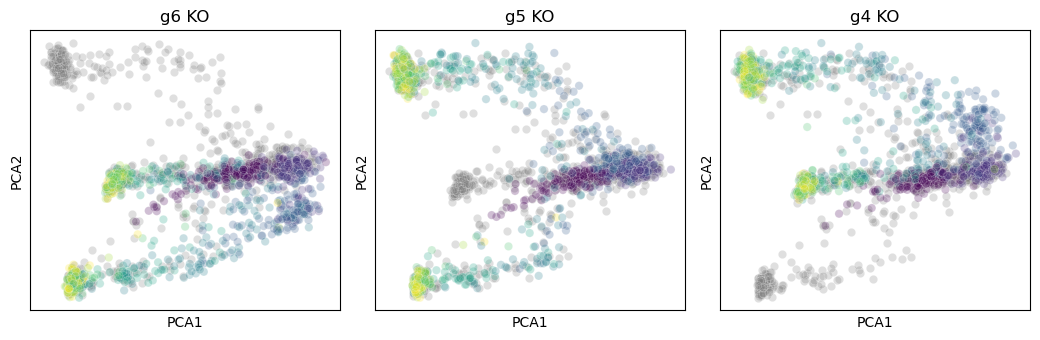

In [319]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
for i in range(3):
    plt.subplot(1, 3, i+1)
    idx = adata_all.obs.condition == "TF"
    sb.scatterplot(x = adata_all.obsm["X_pca"][idx, 0], y = adata_all.obsm["X_pca"][idx, 1], c = 'grey', alpha = 0.25)
    idx_ = adata_all.obs.condition == kos[ko_idx[i+1]]
    sb.scatterplot(x = adata_all.obsm["X_pca"][idx_, 0], y = adata_all.obsm["X_pca"][idx_, 1], alpha = 0.25, c = adata_all.obs.t[idx_])
    plt.title(f"{kos[ko_idx[i+1]]} KO")
    plt.xlabel("PCA1"); plt.ylabel("PCA2")
    plt.xticks([], []); plt.yticks([], [])
plt.tight_layout()
plt.savefig("../figures/TF_fa2.pdf")

In [320]:
# writadata_all.obs.condition == kos[ko_idx[i+1]]e for RENGE
adata_all.write_h5ad("temp_TF.h5ad")

In [321]:
A_renge = pd.read_csv("A_renge_output_TF.csv", index_col = 0).to_numpy()

In [322]:
# plt.figure(figsize = (15, 3.5))
# plt.subplot(1, 4, 1)
# sb.heatmap(pd.DataFrame(estim_joint.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
# plt.gca().invert_yaxis()
# plt.title("Joint")
# plt.subplot(1, 4, 2)
# sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
# plt.gca().invert_yaxis()
# plt.title("Alternating")
# plt.subplot(1, 4, 3)
# sb.heatmap(pd.DataFrame(estim_fixed.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
# plt.gca().invert_yaxis()
# plt.title("Fixed")
# plt.subplot(1, 4, 4)
# sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
# plt.gca().invert_yaxis()
# plt.title("Fixed")

In [349]:
A_ref = A_refs[np.where(np.array(kos) == None)[0][0]].to_numpy(); np.fill_diagonal(A_ref, 0)

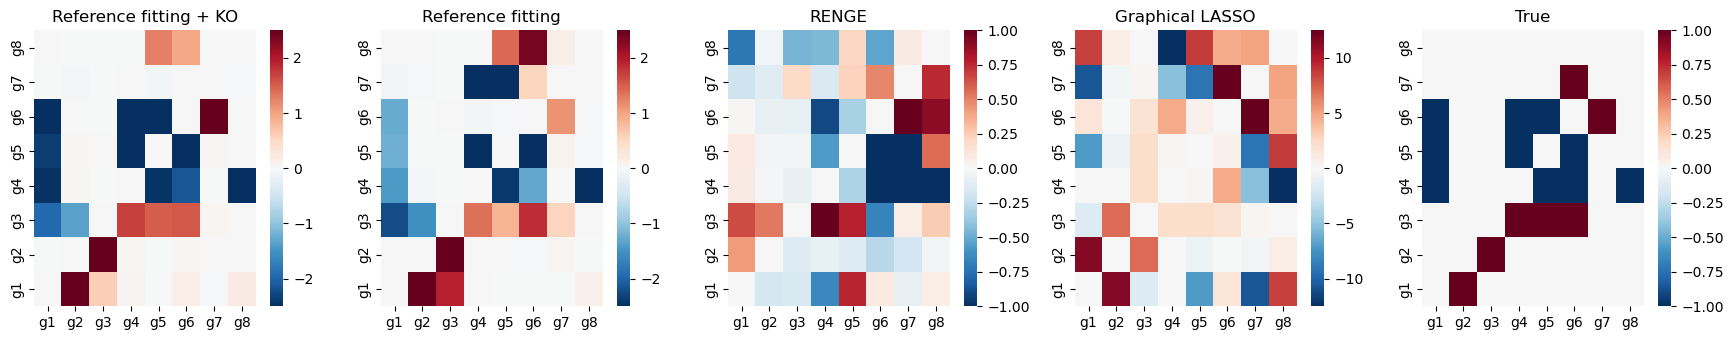

In [361]:
plt.figure(figsize = (5*PLT_CELL, PLT_CELL))
plt.subplot(1, 5, 1)
sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting + KO")
plt.subplot(1, 5, 2)
sb.heatmap(pd.DataFrame(estim_alt_wt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting")
plt.subplot(1, 5, 3)
sb.heatmap(pd.DataFrame(A_renge, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("RENGE")
plt.subplot(1, 5, 4)
sb.heatmap(pd.DataFrame(A_glasso, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -12.5, vmax = 12.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Graphical LASSO")
plt.subplot(1, 5, 5)
sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("True")
plt.tight_layout()

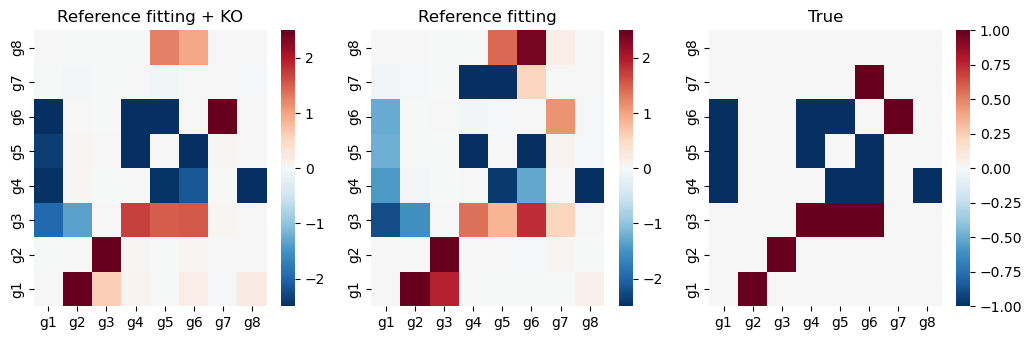

In [362]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting + KO")
plt.subplot(1, 3, 2)
sb.heatmap(pd.DataFrame(estim_alt_wt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting")
plt.subplot(1, 3, 3)
sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("True")
plt.tight_layout()
plt.savefig("../figures/TF_nets_signed.pdf")

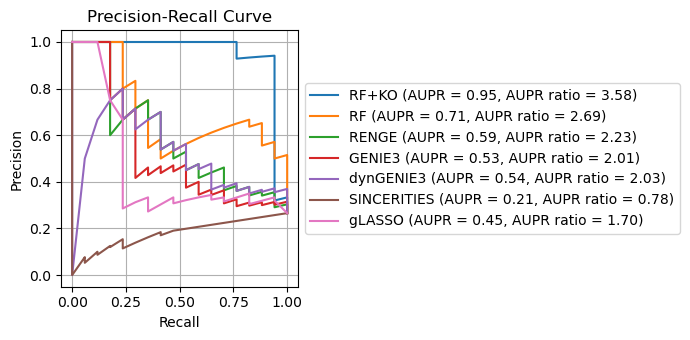

In [363]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = np.abs(np.sign(A_ref).astype(int).flatten())
ys["RF+KO"] = np.abs(estim_alt.A.flatten())
ys["RF"] = np.abs(estim_alt_wt.A.flatten())
ys["RENGE"] = np.abs(A_renge.flatten())
ys["GENIE3"] = np.abs(A_genie3.flatten())
ys["dynGENIE3"] = np.abs(A_dyngenie3.flatten())
ys["SINCERITIES"] = np.abs(A_sincerities.flatten())
ys["gLASSO"] = np.abs(A_glasso.flatten())

plt.figure(figsize=(2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/TF_precision.pdf")

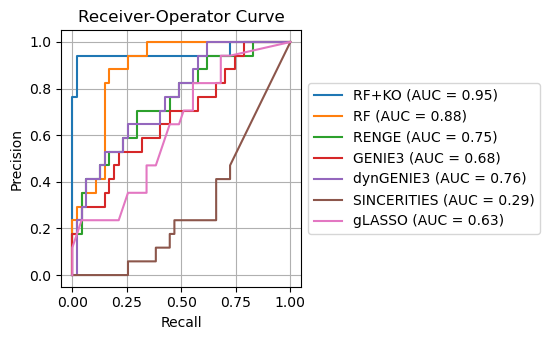

In [364]:
plt.figure(figsize=(1.6*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    fpr, tpr, thresh = roc_curve(y_true, y)
    auc = roc_auc_score(y_true, y)
    plt.plot(fpr, tpr, label=f'{k} (AUC = {auc:.2f})',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Receiver-Operator Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/TF_roc.pdf")

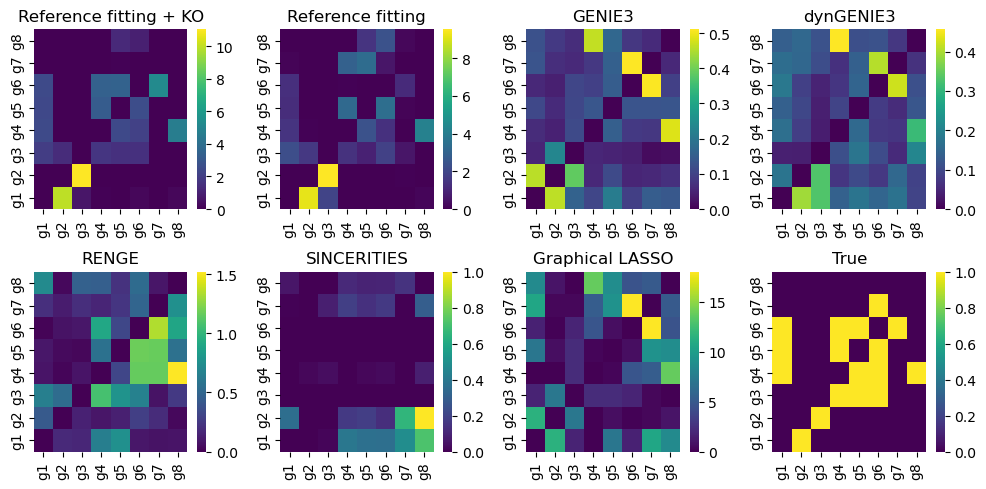

In [365]:
plt.figure(figsize = (10, 5))
plt.subplot(2, 4, 1)
sb.heatmap(pd.DataFrame(np.abs(estim_alt.A), index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("Reference fitting + KO")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 2)
sb.heatmap(pd.DataFrame(np.abs(estim_alt_wt.A), index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("Reference fitting")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 3)
sb.heatmap(pd.DataFrame(A_genie3, index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("GENIE3")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 4)
sb.heatmap(pd.DataFrame(A_dyngenie3, index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("dynGENIE3")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 5)
sb.heatmap(pd.DataFrame(np.abs(A_renge), index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("RENGE")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 6)
sb.heatmap(pd.DataFrame(A_sincerities, index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("SINCERITIES")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 7)
sb.heatmap(pd.DataFrame(np.abs(A_glasso), index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("Graphical LASSO")
plt.gca().invert_yaxis()
plt.subplot(2, 4, 8)
sb.heatmap(pd.DataFrame(np.abs(A_ref), index = adatas[0].var.index, columns = adatas[0].var.index), cmap = "viridis")
plt.title("True")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../figures/TF_nets_unsigned.pdf")

/tmp/ipykernel_1065375/2302943698.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);
/tmp/ipykernel_1065375/2302943698.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


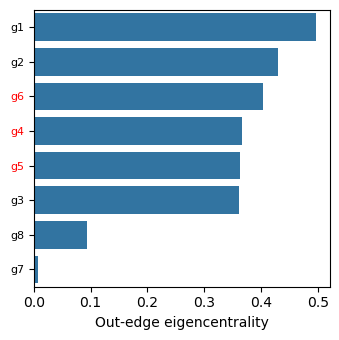

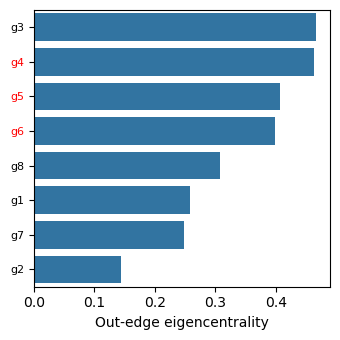

In [329]:
_kos = [kos[i] for i in ko_idx]

for A in [pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adatas[0].var.index, columns = adatas[0].var.index), 
            pd.DataFrame(A_renge, index = adatas[0].var.index, columns = adatas[0].var.index), 
         ]:
    g = nx.DiGraph(np.abs(A))
    centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
    _centralities = pd.Series(centralities)
    plt.figure(figsize = (PLT_CELL, PLT_CELL))
    sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
    plt.yticks(fontsize=8);
    ax = plt.gca()
    y_ticks = ax.get_yticks()
    y_tick_labels = ax.get_yticklabels()
    for label in y_tick_labels:
        if label.get_text() in _kos:
            label.set_color('red')
    ax.set_yticklabels(y_tick_labels);
    plt.xlabel("Out-edge eigencentrality")
    plt.tight_layout()